In [35]:
import nibabel as nib
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import notebook

In [2]:
"""
    data check for kits2019
    
    data folder name : case_00000
    image data file name : imaging.nii.gz
    segmentation data file name : segmentation.nii.gz
    
    < preprocessing should be initialized >
    
    1. resampling - Rethink about resampling => Images must be resampled
        because mask file is not binary but has 3 values (0,1,2) so those values can be removed when resampled => not removed
    2. intensity normalization => What methods?
    
"""

root_dir = '../Data/kits19-master/data/'

example_folder = 'case_00000'

In [3]:
image_file = os.path.join(root_dir, example_folder, 'imaging.nii.gz')
mask_file = os.path.join(root_dir, example_folder, 'segmentation.nii.gz')

In [4]:
image_nii = nib.load(image_file)
mask_nii = nib.load(mask_file)

In [5]:
image_array = image_nii.get_fdata()
mask_array = mask_nii.get_fdata()

In [6]:
dict(image_nii.header)

{'aux_file': array(b'', dtype='|S24'),
 'bitpix': array(64, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'data_type': array(b'', dtype='|S10'),
 'datatype': array(64, dtype=int16),
 'db_name': array(b'', dtype='|S18'),
 'descrip': array(b'', dtype='|S80'),
 'dim': array([  3, 611, 512, 512,   1,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_name': array(b'', dtype='|S16'),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'magic': array(b'n+1', dtype='|S4'),
 'pixdim': array([1.       , 0.5      , 0.9199219, 0.9199219, 1.       , 1.       ,
        1.       , 1.       ], dtype=float32),
 'qform_code': array(0, dtype=int16),
 'qoffset_x': array(0., dtype=float32),
 'qoffset_y': array(0., dtype=float32),
 '

In [7]:
print(image_array.shape)
print(mask_array.shape)

(611, 512, 512)
(611, 512, 512)


In [8]:
# 1 in mask_array represents kidney

xs,ys,zs = np.where(mask_array == 1)
kidney_array = np.zeros(mask_array.shape)

for x,y,z in zip(xs,ys,zs):
    kidney_array[x,y,z] = 1
    
def get_kidney_array(mask_array):
    xs,ys,zs = np.where(mask_array == 1)
    kidney_array = np.zeros(mask_array.shape)

    for x,y,z in zip(xs,ys,zs):
        kidney_array[x,y,z] = 1
        
    return kidney_array

In [9]:
# 2 in mask_array represents tumor

xs,ys,zs = np.where(mask_array == 2)
tumor_array = np.zeros(mask_array.shape)

for x,y,z in zip(xs,ys,zs):
    tumor_array[x,y,z] = 1
    
def get_tumor_array(mask_array):
    xs,ys,zs = np.where(mask_array == 2)
    tumor_array = np.zeros(mask_array.shape)

    for x,y,z in zip(xs,ys,zs):
        tumor_array[x,y,z] = 1
    
    return tumor_array

In [10]:
np.unique(xs)

array([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 341, 342, 343, 344])

In [11]:
def show_slice(slice_num):
    plt.title('image')
    plt.subplot(3,1,1)
    plt.imshow(image_array[slice_num], cmap='gray')
    plt.colorbar()
    
    plt.title('kidney')
    plt.subplot(3,1,2)
    plt.imshow(kidney_array[slice_num], cmap='gray')
    plt.colorbar()

    plt.title('tumor')
    plt.subplot(3,1,3)
    plt.imshow(tumor_array[slice_num], cmap='gray')
    plt.colorbar()
    
    plt.show()

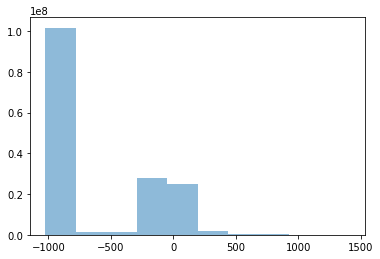

In [12]:
plt.hist(image_array.flatten(), alpha = 0.5,label='image')
# plt.hist(mask_array.flatten(), alpha = 0.5,label='mask')
plt.show()

In [13]:
plt.hist(mask_array.flatten())

(array([1.59235814e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.15679000e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.84910000e+04]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

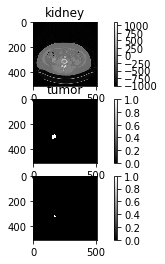

In [14]:
show_slice(338)

In [15]:
def make_mask_bbox(mask_array, slice_num):
    slice_image = mask_array[slice_num]
    y,z = np.where(slice_image == 1)
    
    if len(y) == 0:
        print("there is no sign")
        return (0,0,0), 0, 0
    
    if count_mask_bbox(y,z, slice_image) == 2:
        # do something here to make different bboxes
        print("there are 2 regions")
    else: print("there is only one region")
    
    bl = (np.min(z), np.min(y))
    height = np.max(y) - np.min(y)
    width = np.max(z) - np.min(z)
    
    return bl, width, height

In [16]:
def count_mask_bbox(y, z, slice_image):
    z_mean = int((np.min(z) + np.max(z)) / 2)
    y_mean = int((np.min(y) + np.max(y)) / 2)
    
    if slice_image[y_mean, z_mean] == 0:
        return 2
    else: return 1

there is only one region
there is only one region


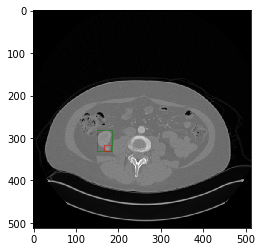

In [17]:
slice_num = 338

# Create figure and axes
fig,ax = plt.subplots(1)

try:
    kidney_bl, kidney_width, kidney_height = make_mask_bbox(kidney_array, slice_num)
    tumor_bl, tumor_width, tumor_height = make_mask_bbox(tumor_array, slice_num)

    # Create a Rectangle patch
    kidney = patches.Rectangle(kidney_bl, kidney_width, kidney_height, linewidth=0.5,edgecolor='g',facecolor='none')
    tumor = patches.Rectangle(tumor_bl, tumor_width, tumor_height, linewidth=0.5,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(kidney)
    ax.add_patch(tumor)

except:
    print("there is error")
    pass

# Display the image
ax.imshow(image_array[slice_num], cmap = 'gray')
plt.show()

## Resampling

### Pix dim check

In [18]:
"""
    Show pix dims are different in dataset
    
    1. y-axis, x-axis ratio is equally 1 : 1 in all dataset
    2. Instead z-axis ratio is different (1, 2, 2.5, 3, 5)
"""
cases = os.listdir(root_dir)
pix_dims = []

for index, case in enumerate(sorted(cases)):
    if 'case' not in case: continue
    
    image_file = os.path.join(root_dir, case, 'imaging.nii.gz')
    mask_file = os.path.join(root_dir, case, 'segmentation.nii.gz')
    
    image_nii = nib.load(image_file)
    image_pix_dim = dict(image_nii.header)['pixdim']
    pix_dims.append(image_pix_dim[1:4])
    
    break
    
np.unique(np.asarray(pix_dims))

array([0.5      , 0.9199219], dtype=float32)

In [23]:
from preprocess.Resample import resample, check_voxel_size, mask2binary

# check original z-axis voxel size
z_voxel,y_voxel,x_voxel = check_voxel_size(nib.load(image_file))

# set resampling target voxel
target_voxel = (z_voxel, 1, 1) # (original z-axis voxel, 1, 1)

# resample with target voxel
resampled_image, image_voxel = resample(image_file, target_voxel)
resampled_mask, image_voxel = resample(mask_file, target_voxel)

# make mask array to binary (tr = )
# resampled_mask = mask2binary(resampled_mask)

In [24]:
# pix dim comparison

print('original voxel size : ', z_voxel, y_voxel, x_voxel)
print('resampled voxel size : ', target_voxel)

# image shape comparison

print('original image shape : ', nib.load(image_file).get_data().shape)
print('resampled image shape : ', resampled_image.shape)

'''
    There is no change in z-axis slice number
    Instead all y-axis, x-axis sizes are resampled into (1, 1)
'''

original voxel size :  0.5 0.9199219 0.9199219
resampled voxel size :  (0.5, 1, 1)


/home/jarvis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


original image shape :  (611, 512, 512)
resampled image shape :  (942, 472, 306)


'\n    There is no change in z-axis slice number\n    Instead all y-axis, x-axis sizes are resampled into (1, 1)\n'

In [40]:
resampled_kidney_array = get_kidney_array(resampled_mask)
resampled_tumor_array = get_tumor_array(resampled_mask)

In [45]:
# slice_num = 30

# # Create figure and axes
# fig,ax = plt.subplots(1)

# try:
#     bl, width, height = make_mask_bbox(resampled_mask, slice_num)

#     # Create a Rectangle patch
#     rect = patches.Rectangle(bl,width,height,linewidth=0.5,edgecolor='r',facecolor='none')

#     # Add the patch to the Axes
#     ax.add_patch(rect)

# except:
#     pass

# # Display the image
# ax.imshow(resampled_image[slice_num], cmap = 'gray')
# plt.show()

there is only one region
there is only one region


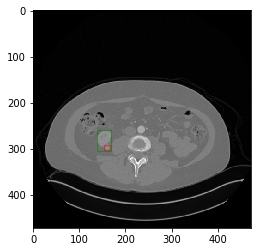

In [53]:
slice_num = 338

# Create figure and axes
fig,ax = plt.subplots(1)

try:
    kidney_bl, kidney_width, kidney_height = make_mask_bbox(resampled_kidney_array, slice_num)
    tumor_bl, tumor_width, tumor_height = make_mask_bbox(resampled_tumor_array, slice_num)

    # Create a Rectangle patch
    kidney = patches.Rectangle(kidney_bl, kidney_width, kidney_height, linewidth=0.5,edgecolor='g',facecolor='none')
    tumor = patches.Rectangle(tumor_bl, tumor_width, tumor_height, linewidth=0.5,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(kidney)
    ax.add_patch(tumor)

except:
    print("there is error")
    pass

# Display the image
ax.imshow(resampled_image[slice_num], cmap = 'gray')
plt.show()

In [36]:
cases = sorted(glob(os.path.join(root_dir, '*/*.nii.gz')))

num_512 = 0
num_other = 0

for case in notebook.tqdm_notebook(cases):
#     print(f"{case.split('/')[-2:]} : {check_voxel_size(nib.load(case))}")
#     print("case {} | size : {}".format(case.split('/')[-1:], nib.load(case).get_data().shape))
    
    if nib.load(case).get_data().shape[1:] != (512, 512):
        num_other += 1
        print(case)
    else:
        num_512 += 1
        
print("size (512, 512) : {}".format(num_512))
print("size other : {}".format(num_other))

/home/jarvis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


../Data/kits19-master/data/case_00160/imaging.nii.gz
../Data/kits19-master/data/case_00160/segmentation.nii.gz

size (512, 512) : 508
size other : 2


In [42]:
case_00160 = [case for case in cases if 'case_00160' in case]

x = nib.load(case_00160[1]).get_data()

/home/jarvis/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


### Configuration

In [90]:
"""
    Training / Test dataset ( for submission ) 으로 이미 구성되어 있음
    
    Training dataset : ~ case_00209
    test dataset : case_00210 ~
    
    1. Make Dataset into 2d slices
    
"""

import imageio
import cv2

In [93]:
import warnings
warnings.filterwarnings('ignore')

save_dir = '/home/jarvis/Desktop/swk/Data/kits_segmentation_data/'

for case in notebook.tqdm_notebook(cases):
    case_num = int(case.split('/')[-2].split('_')[1])
    
    if case_num > 209:
        phase = 'test'
    else:
        phase = 'train'
        
    if phase == 'train':
        continue
    
    if 'segmentation.nii.gz' in case:
        im_save_dir = os.path.join(save_dir, phase, 'label')
    elif 'imaging.nii.gz' in case:
        im_save_dir = os.path.join(save_dir, phase, 'image')
        
    # convert nib image into numpy array
    slices = nib.load(case).get_data()
    
    for index, slice in enumerate(slices):
        save_name = "case_%03d_%03d.npy"%(case_num, index)
        np.save(os.path.join(im_save_dir, save_name), slice)

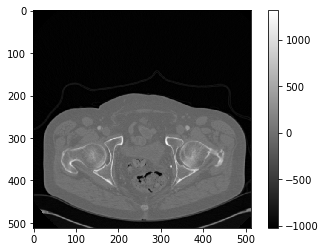

In [94]:
plt.imshow(slice, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
slic

### Preprocessing